# BuyPerfume_Bandits_Problem

In this notebook, we are trying to simulate buying/choosing a perfume with Bernoulli Multi-armed Bandits Problem, also optimize this bantis problem using Thompson Sampling, e-greedy, UBC, and random sampling.

### What is Multi-Armed Bandit?

In probability theory and machine learning, the multi-armed bandit problem is a problem in which a fixed limited set of resources must be allocated between competing (alternative) choices in a way that maximizes their expected gain, when each choice's properties are only partially known at the time of allocation, and may become better understood as time passes or by allocating resources to the choice.This is a classic reinforcement learning problem that exemplifies the exploration–exploitation tradeoff dilemma.[2] 

##### Buy a perfume with MAB problem

First we setup the necessary imports and the standard k-armed bandit. The get_reward_regret samples the reward for the given action, and returns the regret based on the true best action.

We also pre define the reward probability theta of each perfume be:<br>
Perfume A, Woody scent,EDT,low price = 0.5<br>
Perfume B, Fresh scent,EDT,medium price = 0.8<br>
Perfume C, Fresh scent,EDP,high price = 0.6<br>
Perfume D, Floral scent,EDP,medium price = 0.7<br>
Perfume E, Oriental scent,EDP,low price = 0.3<br>
Perfume F, Woody scent,EDP,medium price = 0.4<br>

### Set up Multi-armed bandits environment

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

stationary=True
class Bandit():
  def __init__(self, arm_count):
    """
    Multi-armed bandit with rewards 1 or 0.
    
    At initialization, multiple arms are created. The probability of each arm
    returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
    chosen from Uniform(0,1) at initialization
    """
    self.arm_count = arm_count
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  def generate_thetas(self):
    if (self.arm_count>6):
        self.thetas = np.random.uniform(0,1,self.arm_count)
    else:
        self.thetas = np.asarray([0.5,0.8,0.6,0.7,0.3,0.4])
  
  def get_reward_regret(self, arm):
    """ Returns random reward for arm action. Assumes actions are 0-indexed
    Args:
      arm is an int
    """
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # Simulate bernouilli sampling
    sim = np.random.uniform(0,1,self.arm_count)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[arm]
    regret = self.thetas.max() - self.thetas[arm]
    
    return reward, regret

### Thompson sampling

Thompson sampling is an algorithm for choosing actions that addresses the exploration-exploitation dilemma in the multi-armed bandit problem. It consists of choosing the action that maximizes the expected reward with respect to a randomly drawn belief.

Making the agent begins with a prior belief of the reward of each arm k with a beta distribution, where  𝛼=𝛽=1(the all perfume are equally likely to be selected for experiment).[4]

In [62]:
class BetaAlgo():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward

class BernGreedy(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)
  
  @staticmethod
  def name():
    return 'beta-greedy'
   
  def get_action(self):
    """ Bernouilli parameters are the expected values of the beta"""
    theta = self.alpha / (self.alpha + self.beta)
    return theta.argmax()
  
class BernThompson(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.beta(self.alpha, self.beta)
    return theta.argmax()

For comparison, we also implement the ϵ-greedy algorithm and Upper Confidence Bound (UBC) algorithm. 

### Epsilon greedy(ϵ-greedy)

Epsilon-Greedy is a simple method to balance exploration and exploitation by choosing between exploration and exploitation randomly. The epsilon-greedy, where epsilon refers to the probability of choosing to explore, exploits most of the time with a small chance of exploring.

According to Epsilon greedy algorithm, we choose a random action when probability smaller than epsilon ϵ, otherwise we pick the best action that we have learnt so far.


In [63]:
epsilon = 0.1
class EpsilonGreedy():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global epsilon
    self.epsilon = epsilon
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

### Upper-Confidence Bound

UCB action selection uses uncertainty in the action-value estimates for balancing exploration and exploitation.The selected action follows the rule: 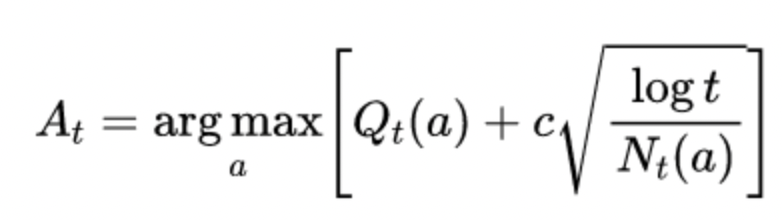
Qt(a) here represents the current estimate for action a at time t. We select the action that has the highest estimated action-value plus the upper-confidence bound exploration term.


In [64]:
ucb_c = 2
class UCB():
  """
  Upper-Confidence Bound
  """
  def __init__(self, bandit):
    global ucb_c
    self.ucb_c = ucb_c
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) + 0.0001 # action count
    self.timestep = 1
  
  @staticmethod
  def name():
    return 'ucb'
  
  def get_action(self):
    ln_timestep = np.log(np.full(self.arm_count, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

### Random Sampling
Below is a random sampling implementation which can be used to compare with the performance of other algorithms.

In [65]:
#@yanpingfu
class RandomSampling():
  """
  Random Sampling
  """
  def __init__(self, bandit):
        self.bandit = bandit
        self.arm_count = bandit.arm_count
  
  @staticmethod
  def name():
    return 'random'
  
  def get_action(self):
    action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    return reward, regret

Below are some helper function.

In [66]:
def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.show()
  
def simulate(simulations, timesteps, arm_count, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(arm_count)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

def experiment(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [EpsilonGreedy, UCB, BernThompson,RandomSampling]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

Above codes except the cell has "#@yanpingfu" on the first line are referred from [1], only modify some arguments and variables.

## Experiments

For all experiments, in each trial the agents are allowed 1000 timesteps to maximize reward. We perform 5000 trials for each experiment.

### 1.Which hyperparameters are important for Thompson Sampling, ϵ-greedy, UBC, and random sampling? Show that they are important

Thompson Sampling algorithm does not have any hyperparameter (aside from our assumed Beta(1,1) prior).
Epsilon ϵ is the important hyperparameter for the ϵ-greedy, and confidence level c is for UBC.
Random Sampling has no hyperparameters.

In the below experiments we changed epsilon ϵ and confidence c to observe their effect on ϵ-greedy and UBC.

#### Baseline

In the first experiment, we aim for a standard setup, inspired by [1]. We set ϵ=0.1 for the ϵ-greedy algorithm, and c=2 for UCB. We can find out that thompson and epsilon-greedy agent quickly converge to a steady regret value after only 200 steps, while the UCB agent continues to converge even at step 1000. The random agents meets its steady regret value even at very begin.

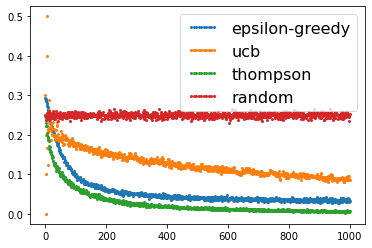

In [77]:
# Experiment 1
arm_count = 6 # number of arms in bandit/perfume 
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

#### Hyperparameter Tunning/Optimization

After hyper-parameter tunning with UCB's confidence c parameter and ϵ-greedy's epsilon ϵ parameter in experiment 3, we can see that if we set the UCB's c parameter to 1, the downtrend line of UCB will become sharper.It quickly converges to a low regret value after only a few dozen steps and outperforms the UCB in experiment 1.

And in experiment 2, when increasing the epsilon ϵ to 0.3, we can observe a massive swing with the epsilon but it is inferior to the previous ϵ-greedy with small epsilon. Then we try to decrease ϵ-greedy's epsilon ϵ parameter to 0.03in experiment 3, it converges slower to low steady regret values even continue the downward trend at strp 1000, but performs better than the previous ϵ-greedy.

It's possible that given few option like only 6 actions, being greedy is a better solution, and exploring is costly and unnecessary.


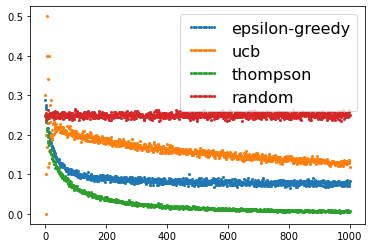

In [78]:
# Experiment 2
arm_count = 6 
epsilon = 0.3 
ucb_c = 3
stationary=True
experiment(arm_count)

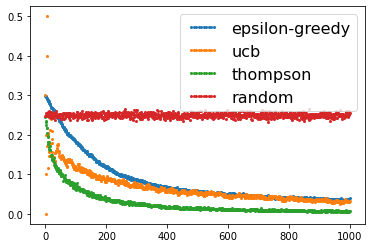

In [79]:
# Experiment 3
arm_count = 6 
epsilon = 0.03 
ucb_c = 1
stationary=True
experiment(arm_count)

### 2.How does the action space affect Thompson Sampling, ϵ-greedy, UBC, and random sampling? Show why. 

In this section,we trying to find out the action space effect on Thompson Sampling, ϵ-greedy, UBC, and random sampling. First we increase arm_count from 6 to 200, and other parameters remained the same as our baseline in experiment 1. 
We can observe that the learning pattern of the greedy agent is almost unchanged compared to the baseline while dramatic fluctuations in the UCB. Also, the thompson sampling shows a slow convergence to a low regret value and is almost close to a steady state at 1000 steps.

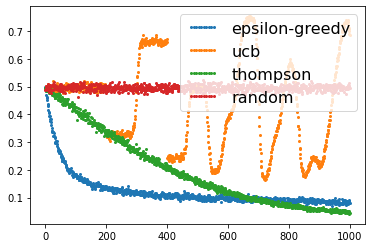

In [80]:
# Experiment 4
arm_count = 200 
epsilon = 0.1 
ucb_c = 2
stationary=True
experiment(arm_count)

Atfer adjust UCB's confidence c and increasing the timesteps to 3000, UCB's learning pattern is approches stability. Thompson and UCB are converge to a very close regret value at steps 3000 and outperform the epsilon greedy agent.

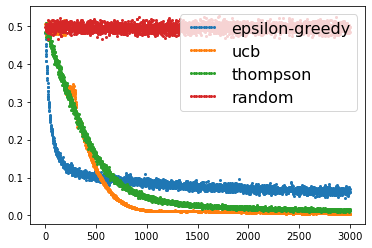

In [81]:
# Experiment 5
arm_count = 200 
epsilon = 0.1 
ucb_c = 0.1
stationary=True
experiment(arm_count, timesteps=3000, simulations=1000)

### 3.How does stationary affect Thompson Sampling, ϵ-greedy, UBC, and random sampling? Show why. 

Now we set the parameters to be the same as the baseline except the environment becomes non-stationary. 
Below we see a noticeable jump in regret every time we resample the true bandit parameters (every 100 steps), this require a higher emphasis on exploration. 
While ϵ-greedy and Thompson show a sharp downward trend in regrets in every 100 steps, on average they increase over time. On the contrary, UCB responds much more quickly to bandit non-stationarity, and improve in regret over time. And in experiment 7 it performs poorly like other algorithms after we change the hyperparameter confidence c of UCB.


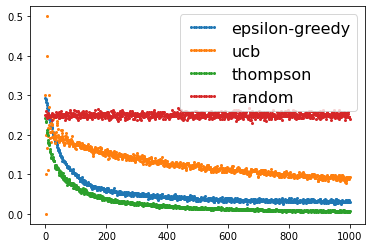

In [82]:
# Experiment 6
arm_count = 6 
epsilon = 0.1 
ucb_c = 2
stationary=False
experiment(arm_count)

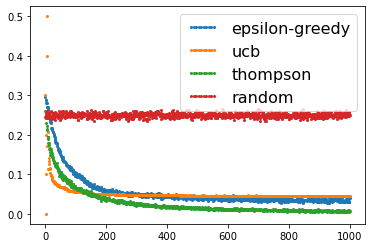

In [83]:
# Experiment 7
arm_count = 6 
epsilon = 0.1 
ucb_c = 0.1
stationary=False
experiment(arm_count)

### 4.When do Thompson Sampling, ϵ-greedy, UBC, and random sampling stop exploring? Explain why. Explain the exploration-exploitation tradeoff 

- Thompson sampling will keep exploring until the simulation is complete, giving it chance to explore and change the beta distribution at the end.
- ϵ-greedy, where epsilon refers to the probability of choosing to explore, exploits most of the time with a small chance of exploring and will keep exploring until the simulation is done.(If epsilon is set to 0, we never explore but always exploit the knowledge we already have).
- UBC doesn't stop exploring till the simulation is done.
- Random sampling will always exploring because the sampling is random.

The exploration-exploitation trade-off is a fundamental dilemma whenever you learn about the world by trying things out. The dilemma is between choosing what you know and getting something close to what you expect ('exploitation') and choosing something you aren't sure about and possibly learning more ('exploration').[5]


### 5.How long do Thompson Sampling, ϵ-greedy, UBC, and random sampling remember the past actions? Explain your answer.

- Thompson Sampling remember past actions when it is running in beta distribution(𝛼 and 𝛽) to select action.
- ϵ-greedy remember past action when it need its data to exploit.
- UCB silimar to ϵ-greedy.
- Random Sampling doesnt remember the past actions because it is completely random. 


### 6.Thompson Sampling with non-Beta distribution. Modify the Thompson Sampling to run with a different distribution (e.g. Parteo, Normal, etc)

The code below is cited from [6].

In [84]:
import math
class ThompsonNormal():
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.mean = np.zeros(self.arm_count)
    self.std = np.zeros(self.arm_count)
    self.n = np.zeros(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.n[arm]+=1
    old_mean = self.mean[arm]
    new_mean = (self.mean[arm]*(self.n[arm]-1) + reward)/self.n[arm]
    self.mean[arm] = new_mean

    old_var = np.power(self.std[arm],2)
    if((self.n[arm]-1)!=0):
      new_var = ((self.n[arm]-2)/(self.n[arm]-1))*old_var + (math.pow((reward-old_mean),2))/self.n[arm]
    else:
      new_var = ((self.n[arm]-2))*old_var + (math.pow((reward-old_mean),2))/self.n[arm]
    self.std[arm] = math.sqrt(new_var)

  @staticmethod
  def name():
    return 'thompson-normal'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.normal(self.mean, self.std)
    return theta.argmax()

In [85]:
def experiment_compare_thompson(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [BernThompson, ThompsonNormal]
 
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

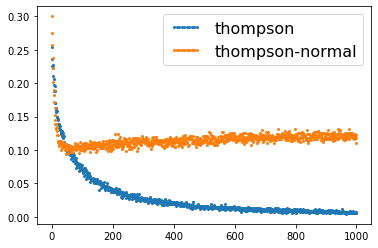

In [86]:
# Experiment 8 : Normal vs. Beta Comparison 
arm_count = 6 # number of arms in bandit
stationary=True
experiment_compare_thompson(arm_count)

### 7.What code is mine and what have i adapted? Did I explain my code clearly?

The code I have added has "#@yanpingfu" on the first line of the cell. In this notebook, I've written the code for Random Sampling based on the existing code and modified experiments to help answer the above questions.  
The bandits environment, thompson, epsilon greedy and UCB code were cited from reference 1, and implementation of Thompson sampling with normal distribution was referred from reference 6.

#### References

[1] https://github.com/andrecianflone/thompson/blob/master/thompson.ipynb<br>
[2] https://en.wikipedia.org/wiki/Multi-armed_bandit<br>
[3] https://lilianweng.github.io/posts/2018-01-23-multi-armed-bandit/<br>
[4] Russo, Daniel, Benjamin Van Roy, Abbas Kazerouni, and Ian Osband. "A Tutorial on Thompson Sampling." arXiv preprint arXiv:1707.02038 (2017).https://arxiv.org/abs/1707.02038<br>
[5] https://tomstafford.staff.shef.ac.uk/?p=48<br>
[6] https://github.com/davidnallapu/MultiArmedBanditProblem/blob/main/BanditProblems.ipynb<br>


### 8.Licensing
Copyright (c) 2022, Yanping Fu All rights reserved.

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.